In [1]:
#!pip install skforecast
# Data processing
# ==============================================================================
import os
import pandas as pd
import numpy as np

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

# Time series modeling
# ==============================================================================
import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold,  OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.model_selection import TimeSeriesFold
from skforecast.preprocessing import RollingFeatures

Downloading the dataset

In [2]:
df1 = pd.read_excel('C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/data_final.xlsx')

In [3]:
df = df1.copy()
#drop missing data
df = df.dropna()

Removing any negative values and unnecassary columns

In [4]:
# Initially include all rows
df["Include"] = True

# Function to tag rows based on conditions
def tag_abnormal_values(df, condition, include_col='Include'):
    """
    Updates the Include column to False for rows that satisfy the given condition.

    :param df: The DataFrame to modify.
    :param condition: A condition (boolean array or series) for abnormal values.
    :param include_col: The column name to update for inclusion.
    :return: Modified DataFrame with updated Include column.
    """
    df.loc[condition, include_col] = False
    return df

# Define conditions for abnormality
conditions = [
    (df['energy_total'] < 1) | (df['energy_total'] > 2800)
]

# Exclude abnormal features
for condition in conditions:
    df = tag_abnormal_values(df, condition)
# Cut out all abnormal values
df = df[df.Include].drop(["Include"], axis=1)

#delete columns 'dhi', 'dni', 'precip', 'snow', 'wind_spd'
df = df.drop(['dhi', 'dni', 'precip', 'snow', 'wind_spd'], axis=1)

#extract the hour from the datetime column
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

#only keep rows where hour is between 8 and 18
df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
#delete three first rows
df = df.iloc[3:]

#drop hour column
df = df.drop(['hour'], axis=1)
df = df.drop(['hour_nr'], axis=1)
df = df.drop(['day_of_year'], axis=1)
df = df.drop(['month_nr'], axis=1)

#start the data from date 2022-03-30 08:00:00
df = df[df['datetime'] >= '2022-03-30 08:00:00']

#delete energy_total in df
df = df.drop(columns=['datetime'], axis=1)

Creating rolling windows for predictive columns, 10, 20, and 30 time periods back (1, 2, and 3 days)

In [5]:
import pandas as pd

# Define columns and window periods
columns_to_window = [
    'clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv'
]
window_periods = [10, 20, 30]

def create_window_features(df, columns, periods):
    """
    Create windowed features for specified columns over given time periods.
    
    Args:
        df (pd.DataFrame): Original DataFrame.
        columns (list): List of column names to create windowed features for.
        periods (list): List of time periods for the windows.
        
    Returns:
        pd.DataFrame: DataFrame with windowed features.
    """
    for col in columns:
        for period in periods:
            df[f'{col}_min_{period}'] = df[col].rolling(window=period).min()
            df[f'{col}_max_{period}'] = df[col].rolling(window=period).max()
            df[f'{col}_lag_{period}'] = df[col].shift(period)
    return df

# Assuming `df` is your DataFrame
df = create_window_features(df, columns_to_window, window_periods)

# Drop rows with NaN values caused by shifting
df = df.dropna()

# Display the first few rows of the updated DataFrame
print(df.head())

     clouds  ghi  pres   slp  solar_rad  temp   uv  energy_total  month_sin  \
175     100  226  1013  1016         91   3.9  0.6        596.28   0.866025   
176     100   87  1013  1016         54   2.9  0.6        260.92   0.866025   
177      97    0  1014  1017          0   1.8  0.0        168.04   0.866025   
191       0  393  1017  1020        393   2.3  2.3        222.96   0.866025   
192      54  509  1018  1021        453   2.5  2.6        541.52   0.866025   

     month_cos  ...  temp_lag_30  uv_min_10  uv_max_10  uv_lag_10  uv_min_20  \
175       -0.5  ...          0.7        0.0        1.4        1.6        0.0   
176       -0.5  ...          2.7        0.6        1.4        0.0        0.0   
177       -0.5  ...          2.8        0.0        1.4        0.8        0.0   
191       -0.5  ...          2.8        0.0        2.3        1.1        0.0   
192       -0.5  ...          1.7        0.0        2.6        1.3        0.0   

     uv_max_20  uv_lag_20  uv_min_30  uv_max

Box Cox transforming target variable to get a normal distribution for the models later on

In [6]:
#box cox transformation of energy_total
from scipy.stats import boxcox
df['energy_total'], lmbda = boxcox(df['energy_total'])

Splitting into training, validation, and test sets 75%, 15%, and 10%

In [8]:
df.reset_index(drop=True, inplace=True)  # Use RangeIndex

train_end = int(0.80 * len(df))
val_end = train_end + int(0.10 * len(df))

df_train = df.iloc[:train_end, :].copy()
df_val = df.iloc[train_end:val_end, :].copy()
df_test = df.iloc[val_end:, :].copy()

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 7786
Validation size: 973
Test size: 974


Standardizing the columns to the same scale, but not the target column

In [9]:
# Calculate mean and standard deviation for all features except 'energy_total'
features_to_scale = [col for col in df_train.columns if col != 'energy_total']
train_mean = df_train[features_to_scale].mean()
train_std = df_train[features_to_scale].std()

# Scale the selected features
df_train[features_to_scale] = (df_train[features_to_scale] - train_mean) / train_std
df_val[features_to_scale] = (df_val[features_to_scale] - train_mean) / train_std
df_test[features_to_scale] = (df_test[features_to_scale] - train_mean) / train_std
df[features_to_scale] = (df[features_to_scale] - train_mean) / train_std

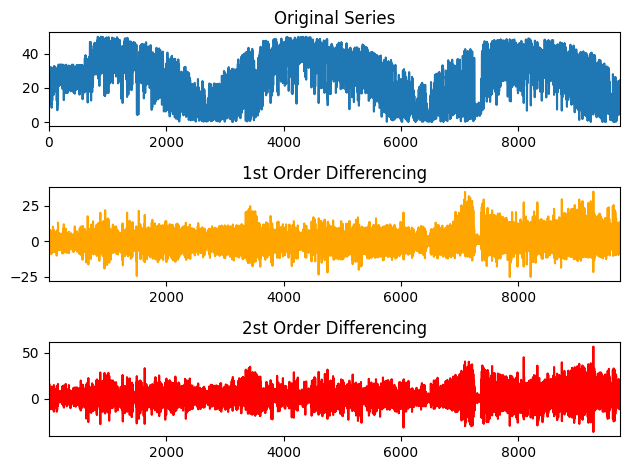

In [10]:
# Lets take a look at the timeseries compared to when we take the 1st and 2nd difference 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.subplots(3, 1)  

# orginal series
plt.subplot(3,1,1)
plt.plot(df['energy_total'])
plt.title('Original Series')
ax = plt.gca()
ax.autoscale(enable=True, axis='x', tight=True)

# 1st order differencing
plt.subplot(3,1,2)
plt.plot(df['energy_total'].diff().dropna(), c='orange')
plt.title('1st Order Differencing')
ax = plt.gca()
ax.autoscale(enable=True, axis='x', tight=True)

plt.subplot(3,1,3)
plt.plot(df['energy_total'].diff().diff().dropna(), c='red')
plt.title('2st Order Differencing')
ax = plt.gca()
ax.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

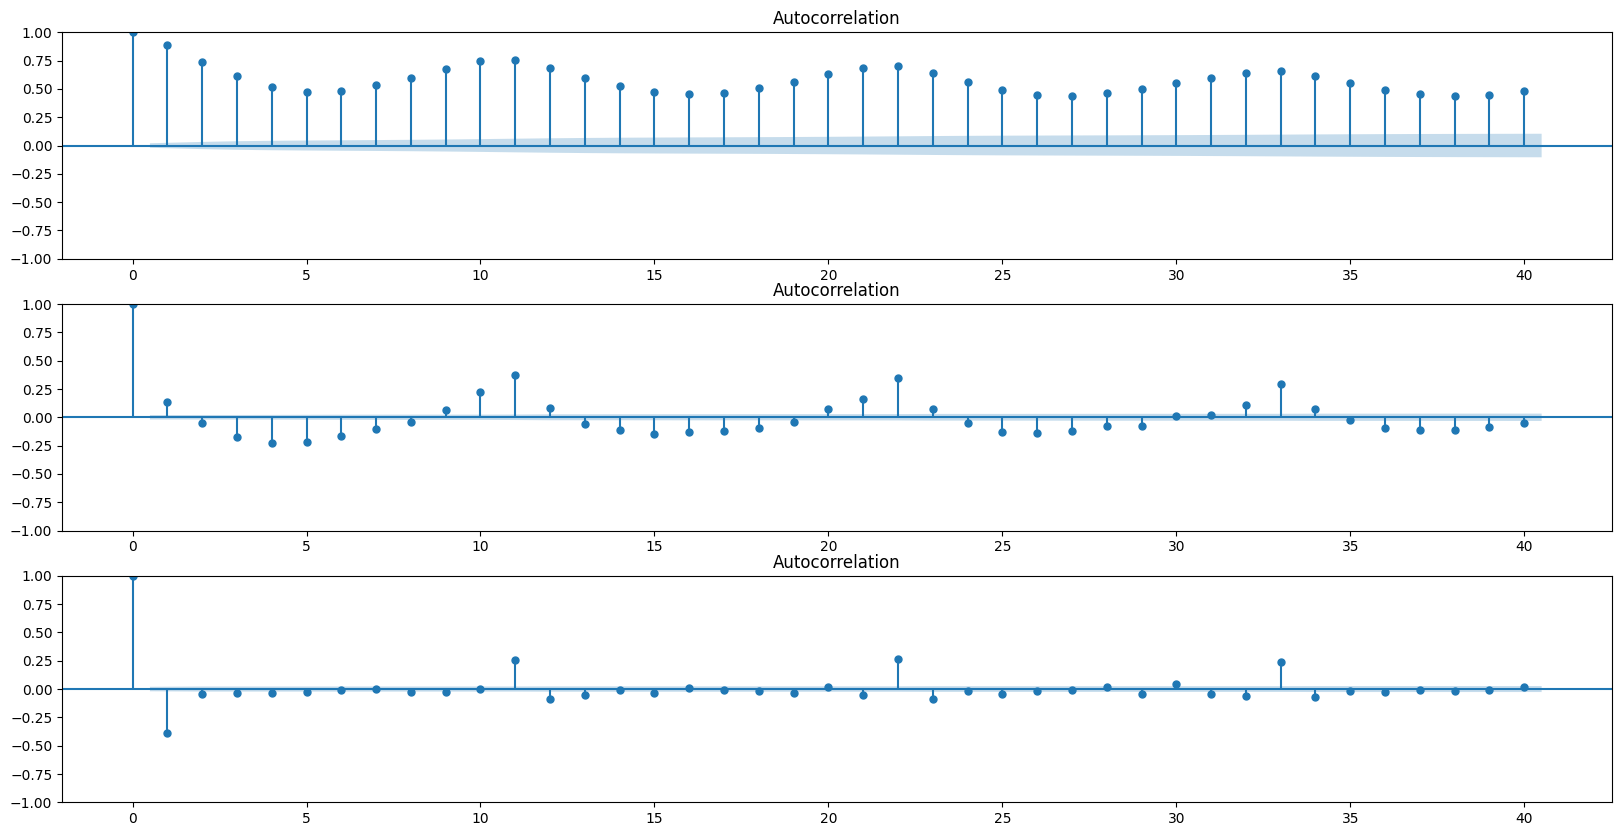

In [11]:
# Visualize the autocorrelation plots so that we can get a better idea of differencing.
fig,ax = plt.subplots(3,1,figsize=(20,10))
fig = plot_acf(df['energy_total'], ax=ax[0])
fig = plot_acf(df['energy_total'].diff().dropna(), ax=ax[1])
fig = plot_acf(df['energy_total'].diff().diff().dropna(), ax=ax[2])

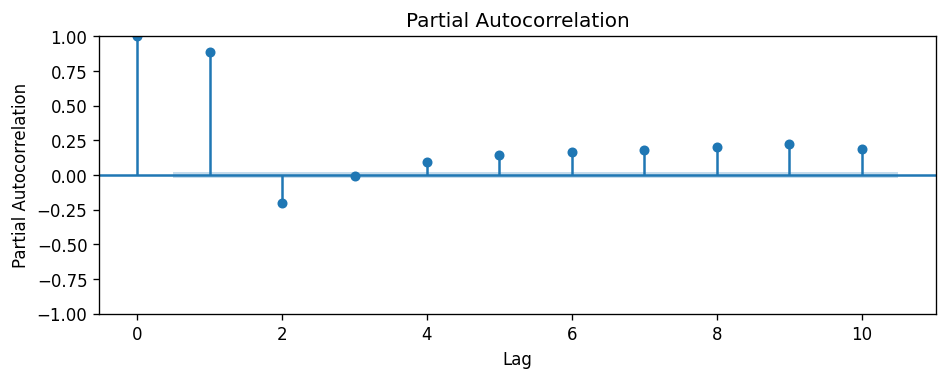

In [12]:
# Plot the PACF
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})
                    
                    
plot_pacf(df['energy_total'], lags=10)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

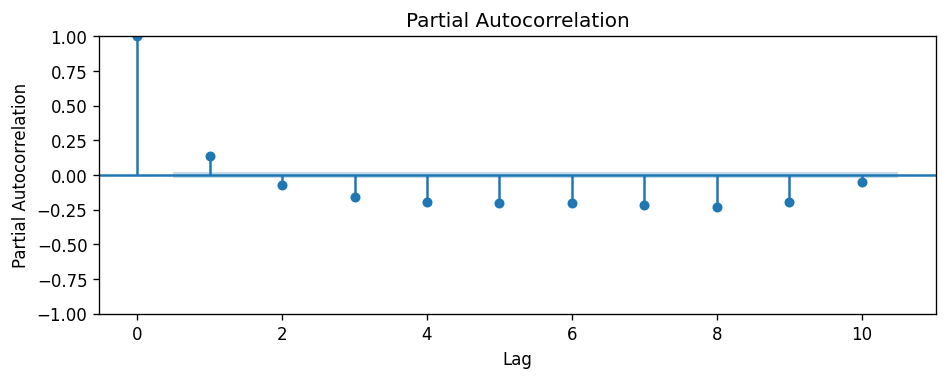

In [13]:
# lets check the differened one as well
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})
                    
                    
plot_pacf(df['energy_total'].diff().dropna(), lags=10)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['energy_total'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.575675687969921
p-value : 0.00014318188301494337
#Lags Used : 34
Number of Observations Used : 9698
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


SARIMAX MODEL

In [15]:
from skforecast.recursive import ForecasterSarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.sarimax import Sarimax


# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model with ForecasterSarimax and skforecast Sarimax
# ==============================================================================
forecaster_sarimax = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
             )
forecaster_sarimax.fit(y=df_train['energy_total'], suppress_warnings=True)

# Prediction
predictions_sarimax = forecaster_sarimax.predict(steps=len(df_val))
predictions_sarimax.head(4)

7786    43.808189
7787    44.405127
7788    43.753840
7789    43.005700
Name: pred, dtype: float64

In [16]:
# Backtest forecaster
# ==============================================================================
forecaster_sarimax = ForecasterSarimax(
                 regressor = Sarimax(
                                order          = (1, 1, 1),
                                seasonal_order =(1, 1, 1, 10),
                                maxiter        = 200
                             )
             )
cv = TimeSeriesFold(
        steps              = 10,
        initial_train_size = len(df[:val_end]),
        refit              = False,
        fixed_train_size   = False,
)
metric_sarimax, predictions_sarimax = backtesting_sarimax(
                        forecaster            = forecaster_sarimax,
                        y                     = df['energy_total'],
                        cv                    = cv,
                        metric                = 'mean_absolute_error',
                        n_jobs                = "auto",
                        suppress_warnings_fit = True,
                        verbose               = True,
                        show_progress         = True
                     )
display(metric_sarimax)
predictions_sarimax.head(4)

Information of folds
--------------------
Number of observations used for initial training: 8759
Number of observations used for backtesting: 974
    Number of folds: 98
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   0 -- 8758  (n=8759)
    Validation: 8759 -- 8768  (n=10)
Fold: 1
    Training:   No training in this fold
    Validation: 8769 -- 8778  (n=10)
Fold: 2
    Training:   No training in this fold
    Validation: 8779 -- 8788  (n=10)
Fold: 3
    Training:   No training in this fold
    Validation: 8789 -- 8798  (n=10)
Fold: 4
    Training:   No training in this fold
    Validation: 8799 -- 8808  (n=10)
Fold: 5
    Training:   No training in this fold
    Validation: 8809 -- 8818  (n=10)
Fold: 6
    Training:   No training in this fold
    Validation: 8819 -- 8828  (n=10)
Fold: 7
    Training:   No tr

  0%|          | 0/98 [00:00<?, ?it/s]

,mean_absolute_error
0,9.233679


,pred
8759,36.889285
8760,34.964244
8761,33.904474
8762,34.754183


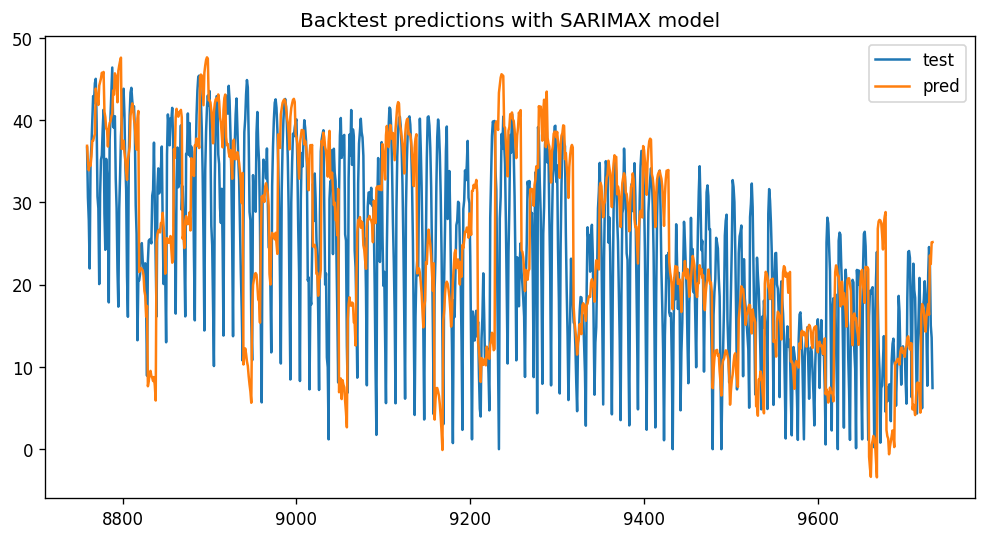

In [19]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
df['energy_total'].loc[val_end:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend();

In [20]:
# Grid search based on backtesting
# ==============================================================================
forecaster_sarimax = ForecasterSarimax(
                 regressor = Sarimax(
                                order   = (1, 1, 1), # Placeholder replaced in the grid search
                                maxiter = 500
                             )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 10), (1, 1, 1, 10)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
        steps              = 10,
        initial_train_size = len(df_train),
        refit              = False,
        fixed_train_size   = False,
    )

results_grid_sarimax = grid_search_sarimax(
                   forecaster            = forecaster_sarimax,
                   y                     = df.loc[:val_end, 'energy_total'],
                   cv                    = cv,
                   param_grid            = param_grid,
                   metric                = 'mean_absolute_error',
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid_sarimax.head(5)

Number of models compared: 45.


params grid:   0%|          | 0/45 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
0,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",7.112517,"(2, 1, 1)","(1, 1, 1, 10)",c
1,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",7.112815,"(2, 1, 1)","(1, 1, 1, 10)",None
2,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",7.112815,"(2, 1, 1)","(1, 1, 1, 10)",n
3,"{'order': (2, 1, 1), 'seasonal_order': (0, 0, ...",7.271542,"(2, 1, 1)","(0, 0, 0, 0)",c
4,"{'order': (2, 1, 1), 'seasonal_order': (0, 0, ...",7.279171,"(2, 1, 1)","(0, 0, 0, 0)",n


In [22]:
from io import StringIO
import contextlib
import re
from pmdarima import auto_arima
# Capture auto_arima trace in a pandas dataframe
# ==============================================================================
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = df.loc[:val_end, 'energy_total'],
            start_p           = 3,
            start_q           = 3,
            max_p             = 6,
            max_q             = 6,
            seasonal          = True,
            test              = 'adf',
            m                 = 10,   # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC").reset_index(drop=True)

,order,seasonal_order,intercept,AIC,Time
0,"(3,0,4)","(0,0,2,10)",intercept,53090.942,45.90
1,"(3,0,4)","(0,0,1,10)",intercept,53101.967,24.89
2,"(4,0,4)","(0,0,2,10)",intercept,53176.018,47.96
3,"(3,0,3)","(0,0,2,10)",intercept,53244.521,42.15
4,"(3,0,3)","(0,0,1,10)",intercept,53244.863,19.08
5,"(3,0,2)","(0,0,2,10)",intercept,53270.658,41.26
6,"(2,0,5)","(0,0,2,10)",intercept,53502.818,52.80
7,"(2,0,4)","(0,0,2,10)",intercept,53533.631,40.70
8,"(3,0,4)","(0,0,2,10)",,53581.908,18.15
9,"(3,0,5)","(0,0,2,10)",intercept,53597.347,49.02


In [28]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster_sarimax = ForecasterSarimax(
                 regressor=Sarimax(order=(3, 1, 4), seasonal_order=(0, 1, 2, 10), maxiter=500),
             )
cv = TimeSeriesFold(
        steps              = 5,
        initial_train_size = len(df.loc[:val_end]),
        refit              = False
)
metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster_sarimax,
                                y                     = df['energy_total'],
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/195 [00:00<?, ?it/s]

In [26]:
# Backtest predictions with the best model according to auto-arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(3, 1, 4), seasonal_order=(0, 1, 2, 10), maxiter=500),
             )
metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster_sarimax,
                                y                     = df['energy_total'],
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/195 [00:00<?, ?it/s]

Metric (mean_absolute_error) for grid search model:


,mean_absolute_error
0,6.313911


Metric (mean_absolute_error) for auto arima-model:


,mean_absolute_error
0,6.694662


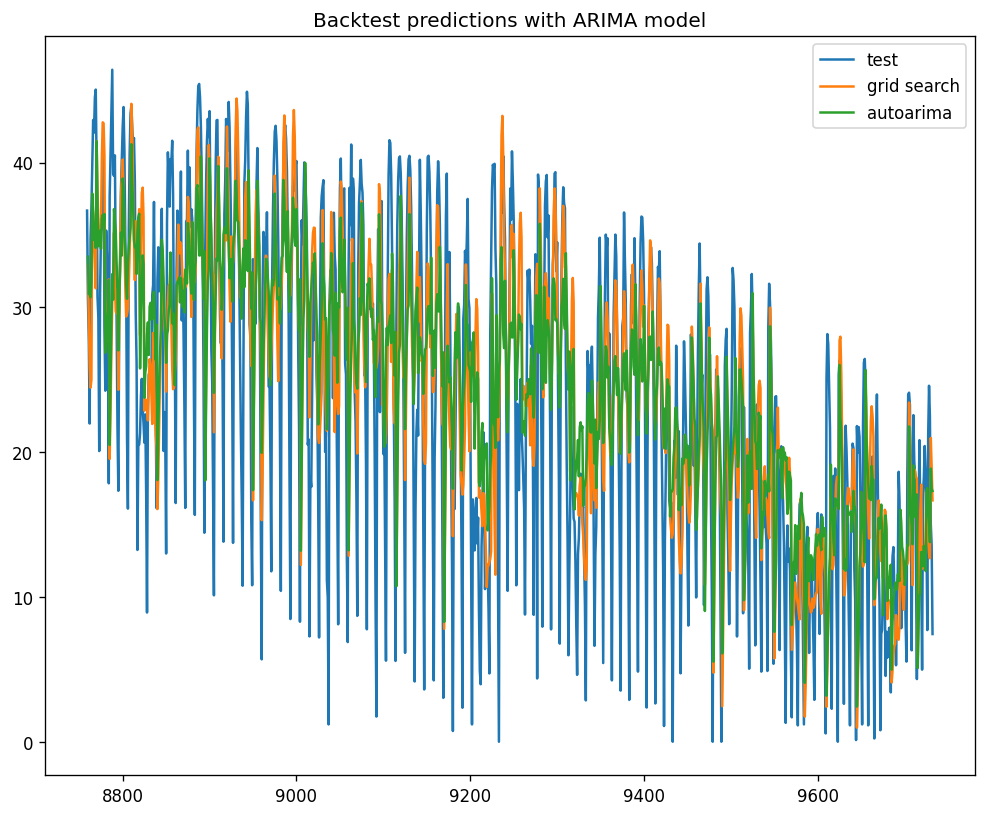

In [30]:
# Compare predictions
# ==============================================================================
print("Metric (mean_absolute_error) for grid search model:")
display(metric_m1)
print("Metric (mean_absolute_error) for auto arima-model:")
display(metric_m2)

fig, ax = plt.subplots(figsize=(10, 8))
df['energy_total'].loc[val_end:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

XGBoosting model

In [31]:
from skforecast.preprocessing import RollingFeatures
from xgboost import XGBRegressor
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=10 * 3)
forecaster_xgb = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True, tree_method='hist'),
                lags            = 10,
                window_features = window_features,
             )

In [32]:
# Folds used for the hyperparameter search and backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(df_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 10,
                    initial_train_size = len(df[:val_end]),
                    refit              = False,
                 )

In [33]:
#define that exog_features are all columns except energy_total
exog_features = [col for col in df.columns if col != 'energy_total']

In [69]:
# Lags used as predictors
lags_grid = [
    [20, 3650],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3650],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 3650]
]

# Enhanced Regressor hyperparameters search space
def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 16, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, step=0.001),
        'subsample': trial.suggest_float('subsample', 0.5, 1, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.05),
        'gamma': trial.suggest_float('gamma', 0, 10, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
        'lags': trial.suggest_categorical('lags', lags_grid),
    }
    return search_space

# Perform the Bayesian search
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster_xgb,
    y=df.loc[:val_end, 'energy_total'],
    exog=df.loc[:val_end, exog_features],
    cv=cv_search,
    search_space=search_space,
    metric='mean_absolute_error',
    n_trials=100,  # Increased number of trials for more exhaustive search
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=True,  # Set to True to monitor progress
    show_progress=True
)

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3    4    5    6    7    8    9   10 3650] 
  Parameters: {'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.011, 'subsample': 1.0, 'colsample_bytree': 0.75, 'gamma': 4.3, 'reg_alpha': 9.3, 'reg_lambda': 1.0, 'min_child_weight': 9}
  One-step-ahead metric: 3.455851647931212


In [73]:
results_search.head(4)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_child_weight
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3650]","{'n_estimators': 700, 'max_depth': 5, 'learnin...",3.455852,700.0,5.0,0.011,1.0,0.75,4.3,9.3,1.0,9.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 400, 'max_depth': 5, 'learnin...",3.467788,400.0,5.0,0.018,1.0,0.85,4.5,9.4,0.2,10.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 5, 'learnin...",3.470621,700.0,5.0,0.015,1.0,0.85,4.7,9.4,0.3,10.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 5, 'learnin...",3.473960,700.0,5.0,0.017,1.0,0.80,4.6,9.3,0.2,9.0


In [70]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_xgboost, predictions_xgb = backtesting_forecaster(
    forecaster    = forecaster_xgb,
    y             = df['energy_total'],
    exog          = df[exog_features],
    cv            = cv_backtesting,
    metric        = 'mean_absolute_error',
    n_jobs        = 'auto',
    verbose       = False,
)
metric_xgboost

  0%|          | 0/98 [00:00<?, ?it/s]

,mean_absolute_error
0,4.906726


Extracting all the exogenous features

In [71]:
# Extract feature importance
# ==============================================================================
importance = forecaster_xgb.get_feature_importances()
importance.head(10)

,feature,importance
0,lag_1,0.256866
11,roll_mean_30,0.212522
18,uv,0.083218
84,uv_max_10,0.061756
16,solar_rad,0.043463
26,cosine_elevation,0.043383
25,sine_elevation,0.032140
1,lag_2,0.027574
13,ghi,0.025065
23,hour_sin,0.011561


In [60]:
from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor
# Create and train forecaster
# ==============================================================================
forecaster_rf = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10,
                 window_features = window_features,
             )

In [90]:
from skforecast.model_selection import grid_search_forecaster
# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(df_train)),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
# Lags used as predictors
lags_grid = {
    'lags_1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3650],
    'lags 2': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 3650]
}

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [250, 300, 400],
    'max_depth': [3, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'random_state': [123]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster_rf,
                     y=df.loc[:val_end, 'energy_total'],
                     exog=df.loc[:val_end, exog_features],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_absolute_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/81 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20 3650] 
  Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250, 'random_state': 123}
  Backtesting metric: 353.22909831411175


In [91]:
# Search results
# ==============================================================================
results_grid.head(4)

,lags,lags_label,params,mean_absolute_error,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,random_state
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",353.229098,10,sqrt,1,5,250,123
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",353.412096,10,sqrt,1,5,300,123
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",354.375678,10,sqrt,1,2,300,123
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",lags 2,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",354.537922,10,sqrt,1,5,400,123


In [92]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor_rf = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=123)
forecaster_rf = ForecasterRecursive(
                 regressor = regressor_rf,
                 lags      = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3650]
             )
forecaster_rf.fit(y=df_train['energy_total'], exog=df_train[exog_features])

KeyboardInterrupt: 

In [79]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_rf, predictions_rf = backtesting_forecaster(
                            forecaster    = forecaster_rf,
                            y             = df['energy_total'],
                            exog          = df[exog_features],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True
                       )
display(metric_rf)
predictions_rf.head()

  0%|          | 0/195 [00:00<?, ?it/s]

,mean_absolute_error
0,4.899385


,pred
7786,45.341135
7787,46.563209
7788,47.122824
7789,46.538007
7790,45.295022


In [80]:
# Extract feature importance
# ==============================================================================
importance_rf = forecaster_rf.get_feature_importances()
importance_rf.head(10)

,feature,importance
0,lag_1,0.831608
15,solar_rad,0.047049
12,ghi,0.018940
24,sine_elevation,0.013523
26,sine_azimuth,0.010543
17,uv,0.007782
25,cosine_elevation,0.005356
6,lag_7,0.004835
7,lag_8,0.003664
8,lag_9,0.003372


In [81]:
#inverse box cox transformation of energy_total for test data and the predictions
from scipy.special import inv_boxcox
df['energy_total'] = inv_boxcox(df['energy_total'], lmbda)
#inverse box cox transformation of energy_total for test data and the predictions
predictions_sarimax = inv_boxcox(predictions_sarimax, lmbda)
predictions_m1 = inv_boxcox(predictions_m1, lmbda)
predictions_m2 = inv_boxcox(predictions_m2, lmbda)
predictions_xgb = inv_boxcox(predictions_xgb, lmbda)
predictions_rf = inv_boxcox(predictions_rf, lmbda)

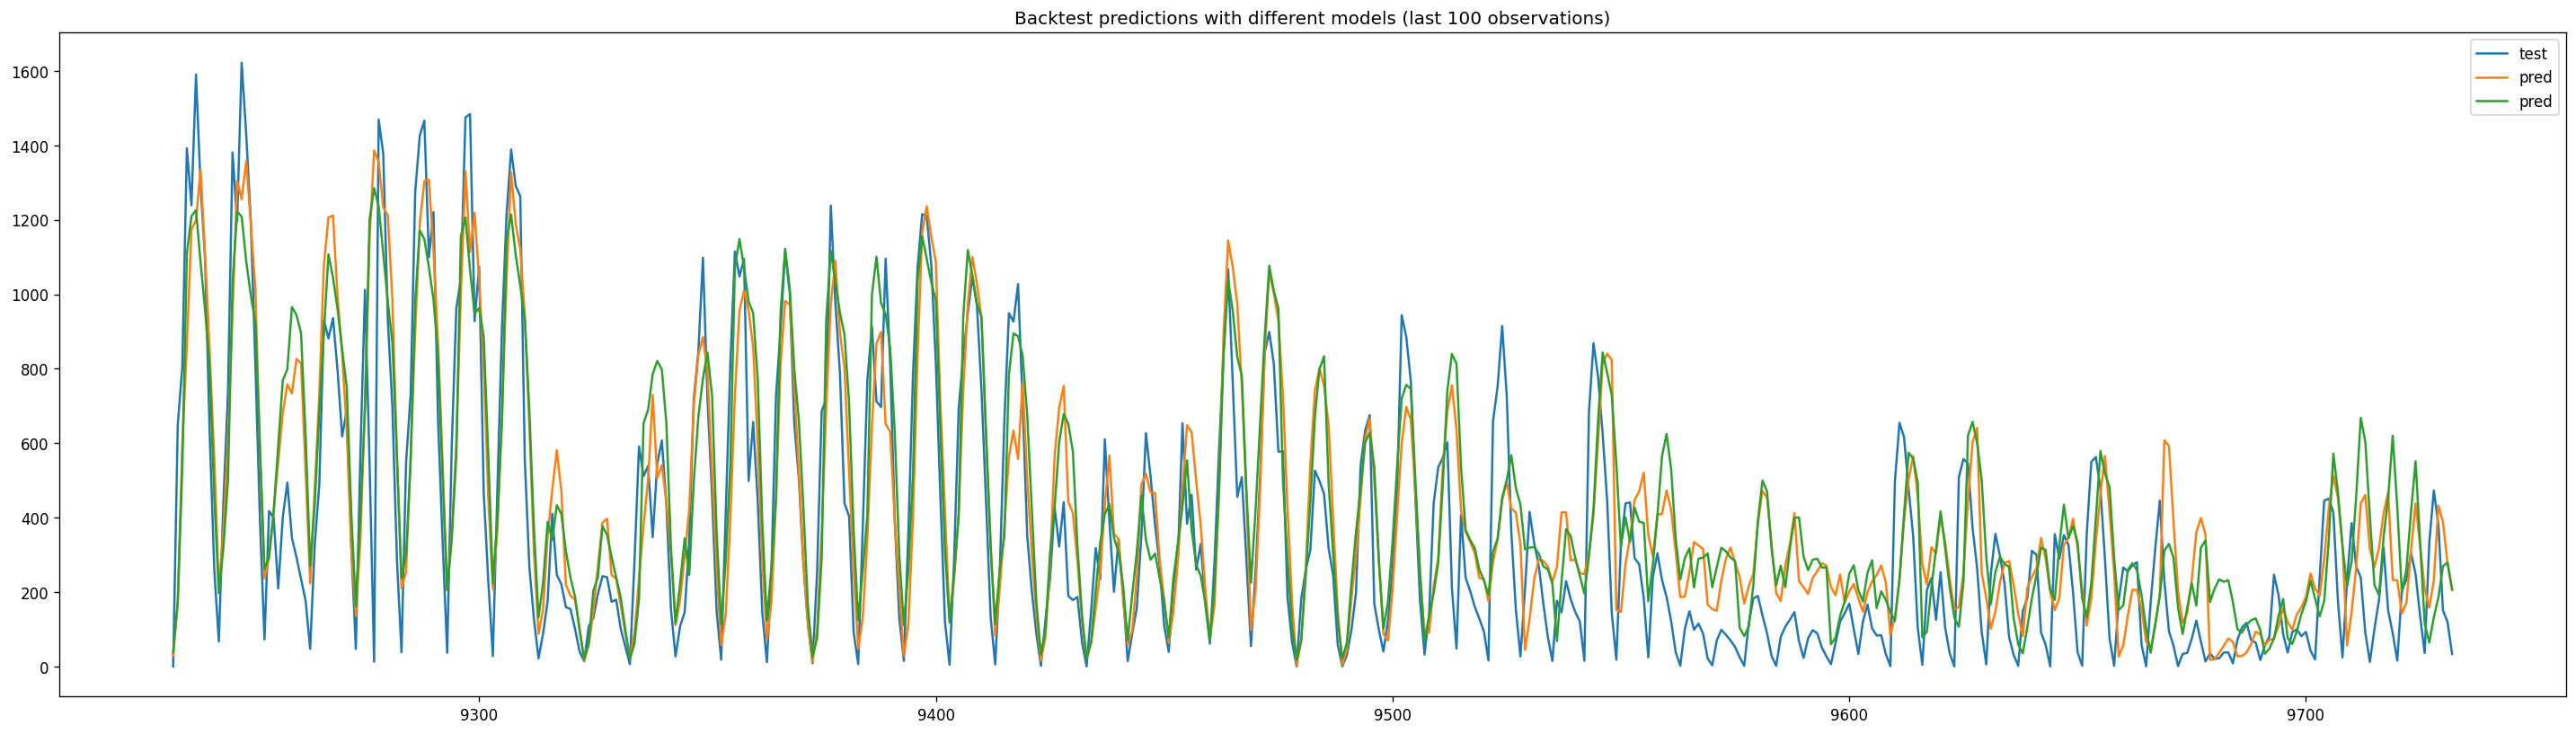

In [88]:
# Plot the last 100 observations
fig, ax = plt.subplots(figsize=(30, 8))
df['energy_total'].loc[val_end:].tail(500).plot(ax=ax, label='test')
#predictions_m1.tail(500).plot(ax=ax, label='Grid search')
predictions_xgb.tail(500).plot(ax=ax, label='XGBoost')
predictions_rf.tail(500).plot(ax=ax, label='Random Forest')
ax.set_title('Backtest predictions with different models (last 100 observations)')
ax.legend()
plt.show()